In [1]:
# Gökhan Has - 161044067
# Data Mining Project
# @01.01.2021


In [2]:
# for dataset operations
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

#for data visualizations
import matplotlib.pyplot as plt
import hdbscan
from sklearn import metrics
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# reading dataset #

In [3]:
data = pd.read_csv('fifa21.csv', index_col=0)
data.head(5)

,Name,Age,OVA,Nationality,Club,BOV,BP,Position,Player Photo,Club Logo,...,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK,Gender
ID,,,,,,,,,,,,,,,,,,,,,
2,G. Pasquale,33,69,Italy,Udinese,71,LWB,LM,https://cdn.sofifa.com/players/000/002/16_120.png,https://cdn.sofifa.com/teams/55/light_60.png,...,70+-1,70+-1,71+-2,70+-1,69+0,69+0,69+0,70+-1,17+0,Male
16,Luis García,37,71,Spain,KAS Eupen,70,CM,CM CAM CDM,https://cdn.sofifa.com/players/000/016/19_120.png,https://cdn.sofifa.com/teams/2013/light_60.png,...,66+1,66+1,62+1,60+1,60+1,60+1,60+1,60+1,17+1,Male
27,J. Cole,33,71,England,Coventry City,71,CAM,CAM RM RW LM,https://cdn.sofifa.com/players/000/027/16_120.png,https://cdn.sofifa.com/teams/1800/light_60.png,...,54+0,54+0,52+0,47+0,46+0,46+0,46+0,47+0,15+0,Male
36,D. Yorke,36,68,Trinidad &amp; Tobago,Sunderland,70,ST,NaN,https://cdn.sofifa.com/players/000/036/09_120.png,https://cdn.sofifa.com/teams/106/light_60.png,...,65+0,65+0,56+0,57+0,51+0,51+0,51+0,57+0,22+0,Male
41,Iniesta,36,81,Spain,Vissel Kobe,82,CAM,CM CAM,https://cdn.sofifa.com/players/000/041/20_120.png,https://cdn.sofifa.com/teams/101146/light_60.png,...,73+3,73+3,70+3,67+3,64+3,64+3,64+3,67+3,17+3,Male


In [4]:
# maas bilgilerini ceviren fonksiyon
def convert_money(val):
    result = val.replace('€', '')
    if 'M' in result:
        result = float(result.replace('M', ''))*1000000
    elif 'K' in result:
        result = float(result.replace('K', ''))*1000
    return float(result)

In [5]:
# maas bilgilerini teker teker düzenleme islemi
data['Value'] = data['Value'].apply(lambda x: convert_money(x))
data['Wage'] = data['Wage'].apply(lambda x: convert_money(x))

data[['Value','Wage']].head()

,Value,Wage
ID,,
2,625000.0,7000.0
16,600000.0,7000.0
27,1100000.0,15000.0
36,0.0,0.0
41,5500000.0,12000.0


In [6]:
# veriyi temizleme islemi gerekli, çünkü maas bilgileri 0 olan oyuncular bulunmakta
data = data[(data['Value'] != 0) | (data['Wage'] != 0)]

In [7]:
# bundan sonraki islemler yedek veri üzerinden yapılacaktır. Cunkü veri görselleştirmede kullanılacaktır.
backup_data = data.dropna(subset=['Position'])[['Name', 'Position', 'OVA', 'BOV'] + data.select_dtypes('float64').columns.tolist()]
backup_data.head()

,Name,Position,OVA,BOV,Value,Wage,Volleys,Curve,Agility,Balance,Jumping,Interceptions,Positioning,Vision,Composure,Sliding Tackle
ID,,,,,,,,,,,,,,,,
2,G. Pasquale,LM,69,71,625000.0,7000.0,58.0,65.0,68.0,68.0,68.0,69.0,63.0,66.0,NaN,69.0
16,Luis García,CM CAM CDM,71,70,600000.0,7000.0,68.0,79.0,62.0,72.0,54.0,71.0,72.0,73.0,79.0,40.0
27,J. Cole,CAM RM RW LM,71,71,1100000.0,15000.0,75.0,84.0,71.0,75.0,58.0,39.0,69.0,74.0,NaN,30.0
41,Iniesta,CM CAM,81,82,5500000.0,12000.0,79.0,80.0,79.0,75.0,40.0,70.0,78.0,93.0,89.0,56.0
61,D. Odonkor,RW RM,66,66,725000.0,5000.0,57.0,61.0,75.0,85.0,70.0,26.0,63.0,58.0,NaN,31.0


In [8]:
# değeri en düşük ile en fazla olan oyuncuların değerleri
backup_data['Value'].min(), backup_data['Value'].max()

(0.0, 105500000.0)

In [9]:
# maaşı en düşük ile en fazla olan oyuncuların değerleri
backup_data['Wage'].min(), backup_data['Wage'].max()

(0.0, 560000.0)

In [10]:
# Standart Scaler İşlemleri
scaler = StandardScaler()
backup_data['Value'] = scaler.fit_transform(backup_data['Value'].values.reshape(-1, 1))
backup_data['Wage'] = scaler.fit_transform(backup_data['Wage'].values.reshape(-1, 1))

In [11]:
# scaler dan sonra değeri en düşük ile en fazla olan oyuncuların değerleri
backup_data['Value'].min(), backup_data['Value'].max()

(-0.48780889311623127, 18.77707275578192)

In [12]:
# scaler den sonra maaşı en düşük ile en fazla olan oyuncuların değerleri
backup_data['Wage'].min(), backup_data['Wage'].max()

(-0.5022012209051251, 25.5555307881074)

In [13]:
# Veri temizleme islemi
for col in data.select_dtypes('float64'):
    if col != 'Value' and col != 'Wage':
        backup_data[col] = pd.qcut(backup_data[col], 10, labels=False, duplicates='drop')

In [14]:
backup_data.head()

,Name,Position,OVA,BOV,Value,Wage,Volleys,Curve,Agility,Balance,Jumping,Interceptions,Positioning,Vision,Composure,Sliding Tackle
ID,,,,,,,,,,,,,,,,
2,G. Pasquale,LM,69,71,-0.373680,-0.176480,7,7,5,5,5,8,6,7,NaN,8
16,Luis García,CM CAM CDM,71,70,-0.378246,-0.176480,9,9,3,6,1,8,8,9,9.0,3
27,J. Cole,CAM RM RW LM,71,71,-0.286943,0.195774,9,9,6,7,2,3,8,9,NaN,3
41,Iniesta,CM CAM,81,82,0.516521,0.056179,9,9,8,7,0,8,9,9,9.0,5
61,D. Odonkor,RW RM,66,66,-0.355420,-0.269543,7,6,7,9,6,2,6,5,NaN,3


# VISUALIZATION #

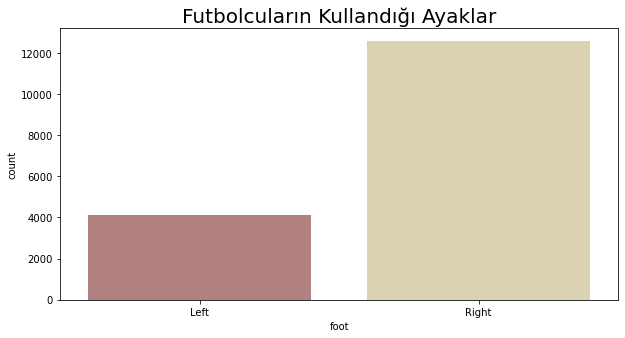

In [15]:
# Futbolcuların Kullandığı Ayaklar

plt.rcParams['figure.figsize'] = (10, 5)
sns.countplot(data['foot'], palette = 'pink')
plt.title('Futbolcuların Kullandığı Ayaklar', fontsize = 20)
plt.show()

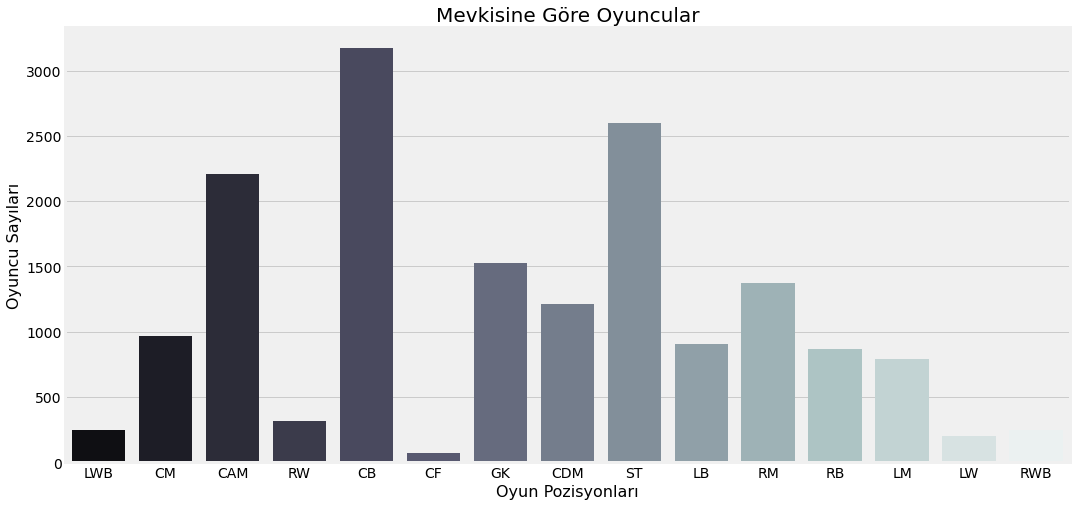

In [16]:
# mevkisine göre oyuncu sayıları

plt.figure(figsize = (18, 8))
plt.style.use('fivethirtyeight')
ax = sns.countplot('BP', data = data, palette = 'bone')
ax.set_xlabel(xlabel = 'Oyun Pozisyonları', fontsize = 16)
ax.set_ylabel(ylabel = 'Oyuncu Sayıları', fontsize = 16)
ax.set_title(label = 'Mevkisine Göre Oyuncular', fontsize = 20)
plt.show()


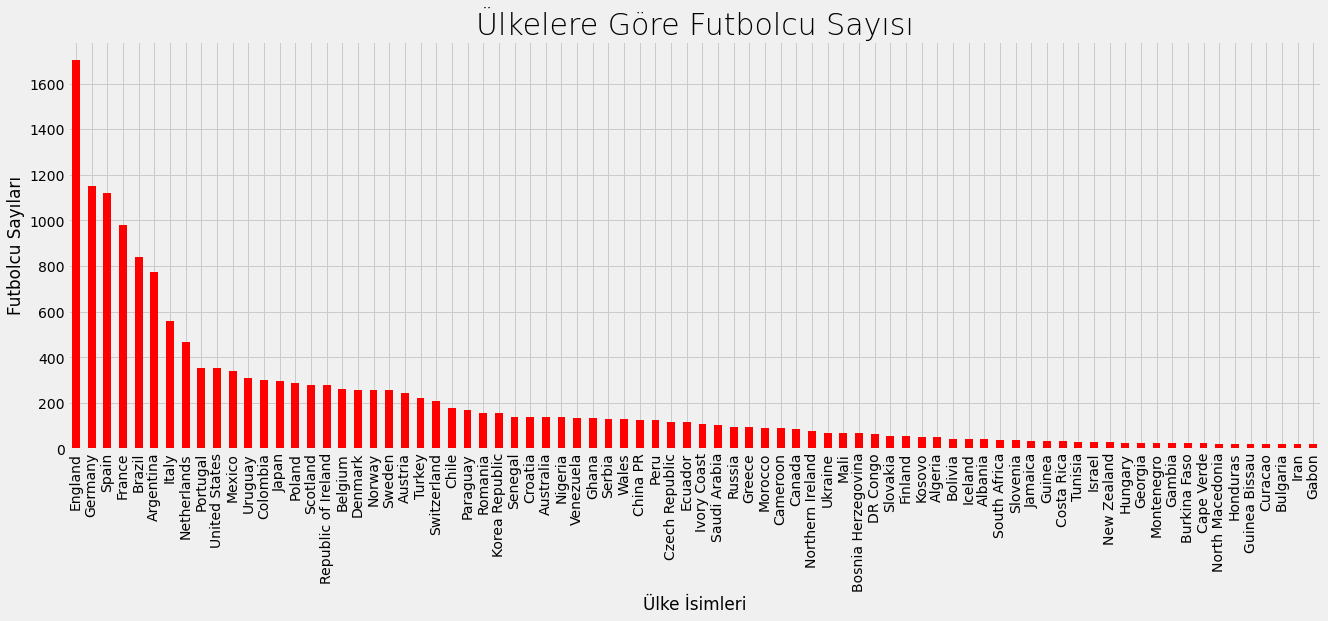

In [17]:
# Ülkesine göre futbolcular

#plt.style.use('dark_background')
data['Nationality'].value_counts().head(80).plot.bar(color = 'red', figsize = (20, 7))
plt.title('Ülkelere Göre Futbolcu Sayısı', fontsize = 30, fontweight = 20)
plt.xlabel('Ülke İsimleri')
plt.ylabel('Futbolcu Sayıları')
plt.show()

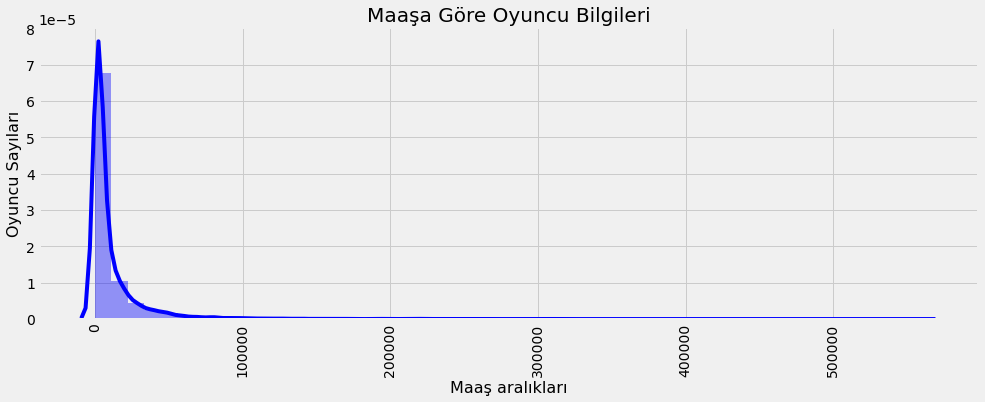

In [18]:
# Aldıkları maaşa göre futbolcu grafiği

plt.rcParams['figure.figsize'] = (15, 5)
sns.distplot(data['Wage'], color = 'blue')
plt.xlabel('Maaş aralıkları', fontsize = 16)
plt.ylabel('Oyuncu Sayıları', fontsize = 16)
plt.title('Maaşa Göre Oyuncu Bilgileri', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

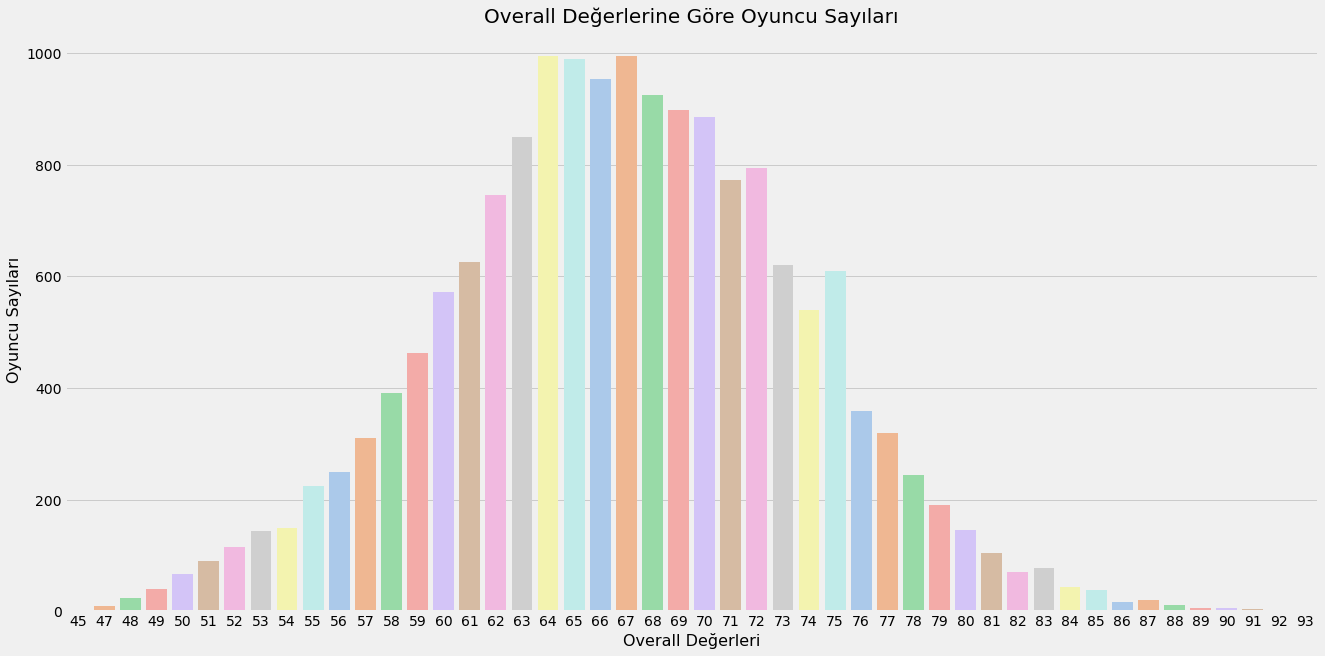

In [19]:
# Overall değerlerine göre oyuncu sayıları

plt.figure(figsize = (20, 10))
ax = sns.countplot(x = 'OVA', data = data, palette = 'pastel')
ax.set_title(label = 'Overall Değerlerine Göre Oyuncu Sayıları', fontsize = 20)
ax.set_xlabel(xlabel = 'Overall Değerleri', fontsize = 16)
ax.set_ylabel(ylabel = 'Oyuncu Sayıları', fontsize = 16)
plt.show()

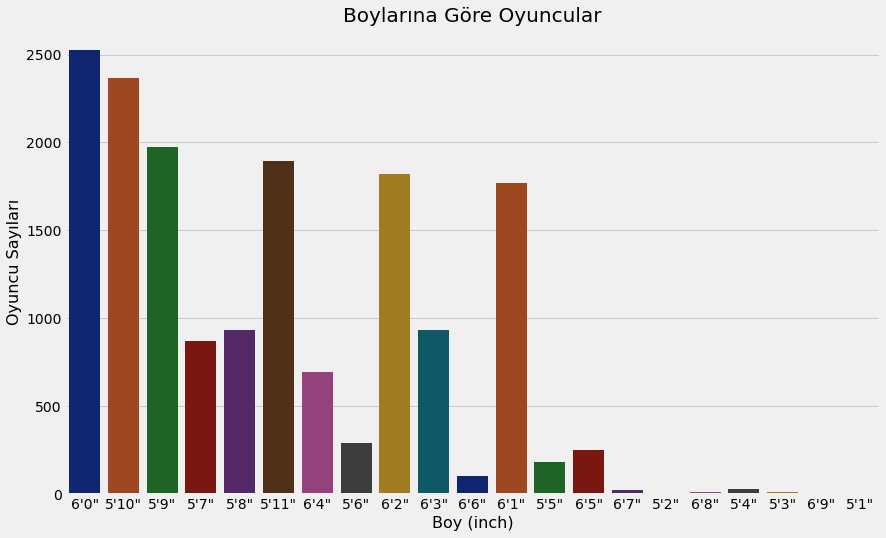

In [20]:
# Oyuncuların boyları ...

plt.figure(figsize = (13, 8))
ax = sns.countplot(x = 'Height', data = data, palette = 'dark')
ax.set_title(label = 'Boylarına Göre Oyuncular', fontsize = 20)
ax.set_xlabel(xlabel = 'Boy (inch)', fontsize = 16)
ax.set_ylabel(ylabel = 'Oyuncu Sayıları', fontsize = 16)
plt.show()


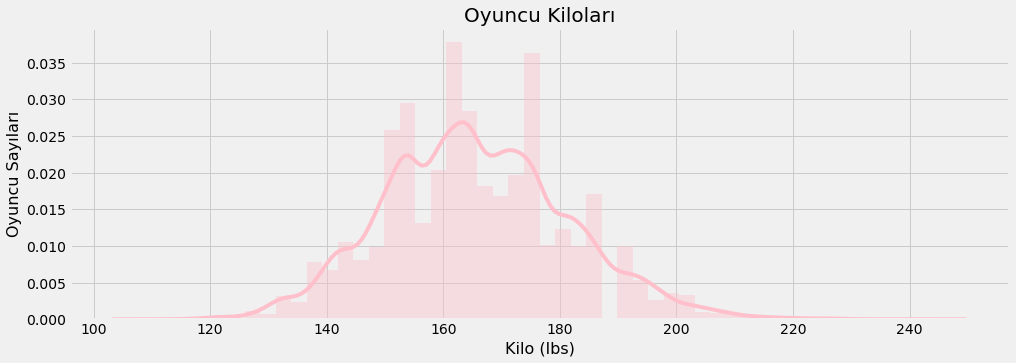

In [21]:
# Oyuncuların kiloları ...

data['Weight'] = data['Weight'].apply(lambda x: x.replace('lbs',''))

plt.figure(figsize = (15, 5))
sns.distplot(data['Weight'], color = 'pink')
plt.title('Oyuncu Kiloları', fontsize = 20)
plt.xlabel('Kilo (lbs)', fontsize = 16)
plt.ylabel('Oyuncu Sayıları', fontsize = 16)
plt.show()

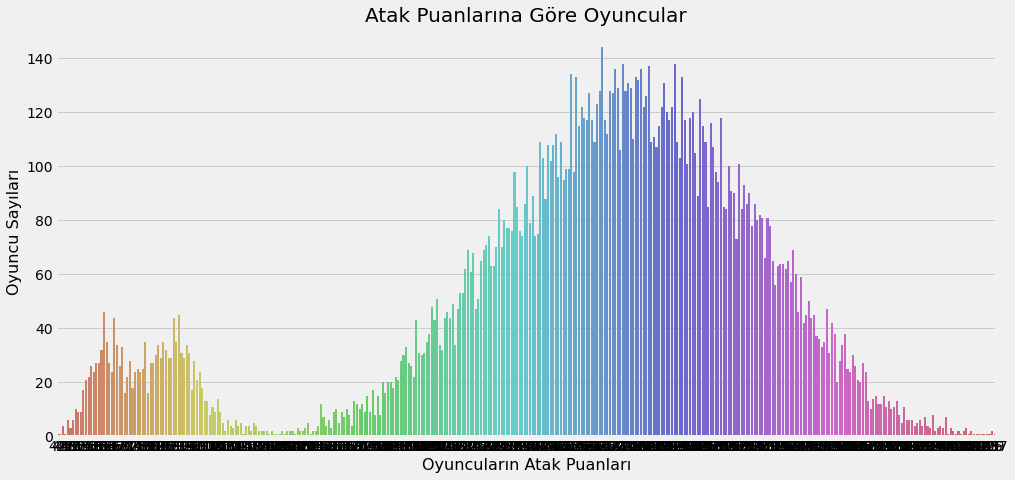

In [22]:
# Oyuncuların Atak Puanlarının Gösterilmesi

plt.figure(figsize = (15, 7))

sns.countplot(x = 'Attacking', data = data, palette = 'hls')
plt.title('Atak Puanlarına Göre Oyuncular', fontsize = 20)
plt.xlabel('Oyuncuların Atak Puanları', fontsize = 16)
plt.ylabel('Oyuncu Sayıları', fontsize = 16)
plt.show()

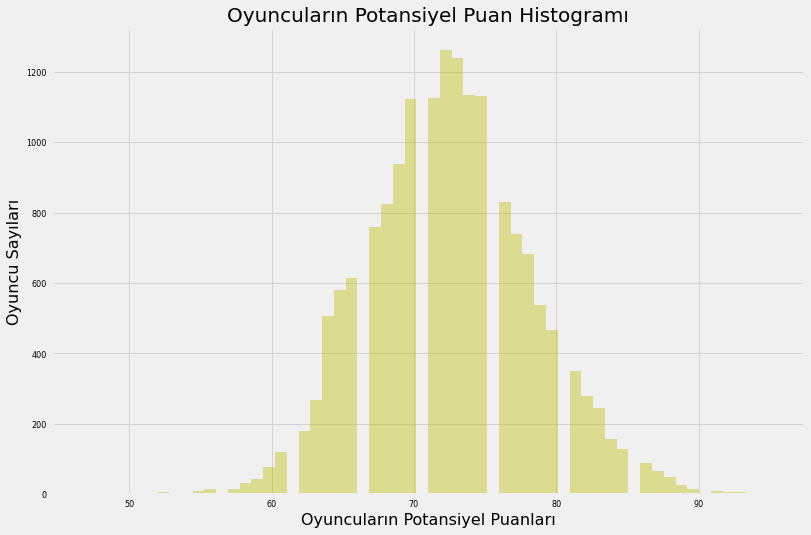

In [23]:
# Oyuncuların potansiyel puanlarının histogramı

x = data.POT
plt.figure(figsize=(12,8))
plt.style.use('seaborn-paper')

ax = sns.distplot(x, bins = 58, kde = False, color = 'y')
ax.set_xlabel(xlabel = "Oyuncuların Potansiyel Puanları", fontsize = 16)
ax.set_ylabel(ylabel = 'Oyuncu Sayıları', fontsize = 16)
ax.set_title(label = 'Oyuncuların Potansiyel Puan Histogramı', fontsize = 20)
plt.show()

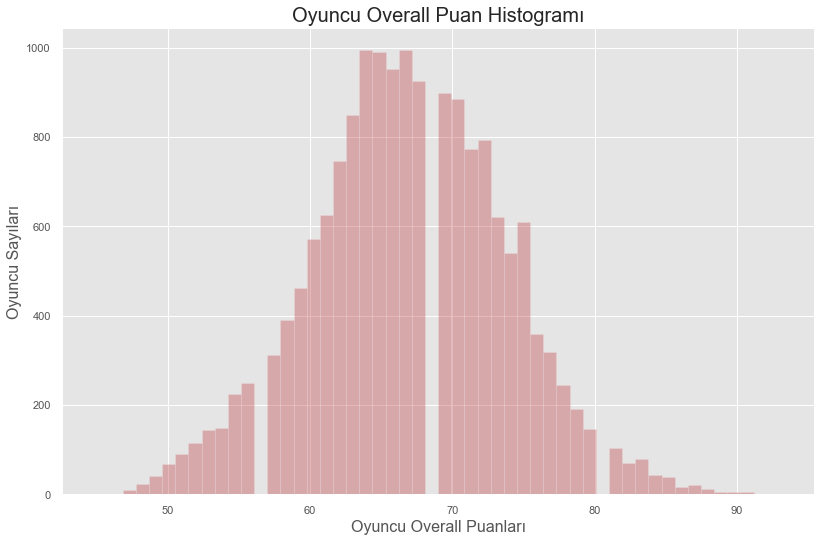

In [24]:
# Oyuncuların genel puanlarının histogramı

sns.set(style = "dark", palette = "deep", color_codes = True)
x = data.OVA
plt.figure(figsize = (12,8))
plt.style.use('ggplot')

ax = sns.distplot(x, bins = 52, kde = False, color = 'r')
ax.set_xlabel(xlabel = "Oyuncu Overall Puanları", fontsize = 16)
ax.set_ylabel(ylabel = 'Oyuncu Sayıları', fontsize = 16)
ax.set_title(label = 'Oyuncu Overall Puan Histogramı', fontsize = 20)
plt.show()

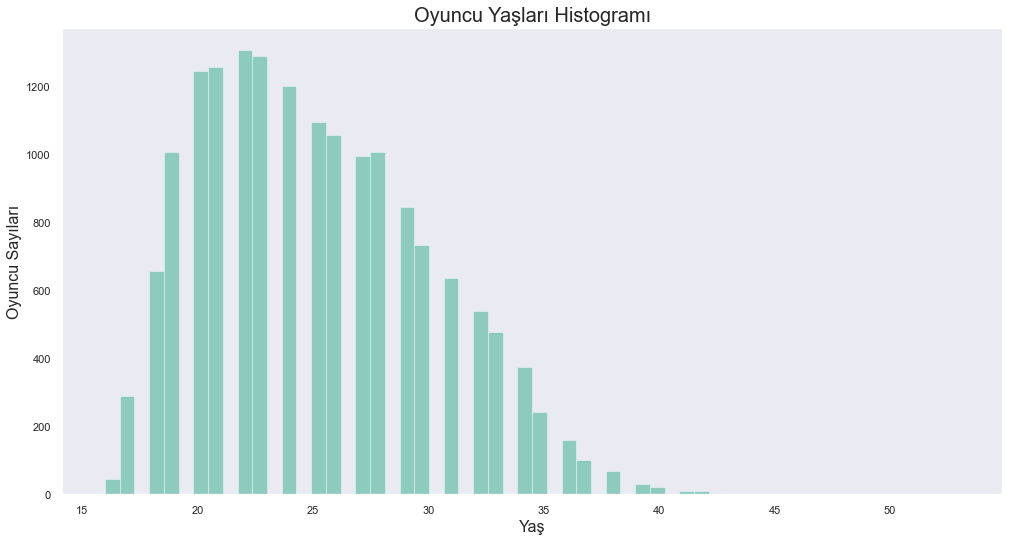

In [25]:
# Hangi oyuncuların yaşlarının aynı olduğunun gösterimi

sns.set(style = "dark", palette = "colorblind", color_codes = True)
x = data.Age
plt.figure(figsize = (15,8))
ax = sns.distplot(x, bins = 58, kde = False, color = 'g')
ax.set_xlabel(xlabel = "Yaş", fontsize = 16)
ax.set_ylabel(ylabel = 'Oyuncu Sayıları', fontsize = 16)
ax.set_title(label = 'Oyuncu Yaşları Histogramı', fontsize = 20)
plt.show()

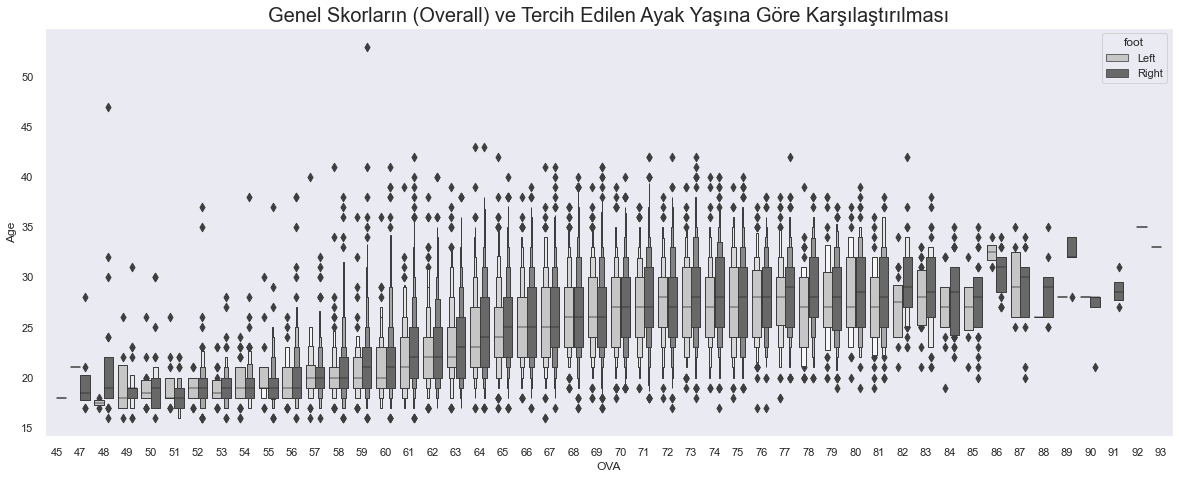

In [26]:
# Genel Skorların (Overall) ve Tercih Edilen Ayak Yaşına Göre Karşılaştırılması

plt.rcParams['figure.figsize'] = (18, 7)
plt.style.use('seaborn-dark-palette')

sns.boxenplot(data['OVA'], data['Age'], hue = data['foot'], palette = 'Greys')
plt.title('Genel Skorların (Overall) ve Tercih Edilen Ayak Yaşına Göre Karşılaştırılması', fontsize = 20)
plt.show()

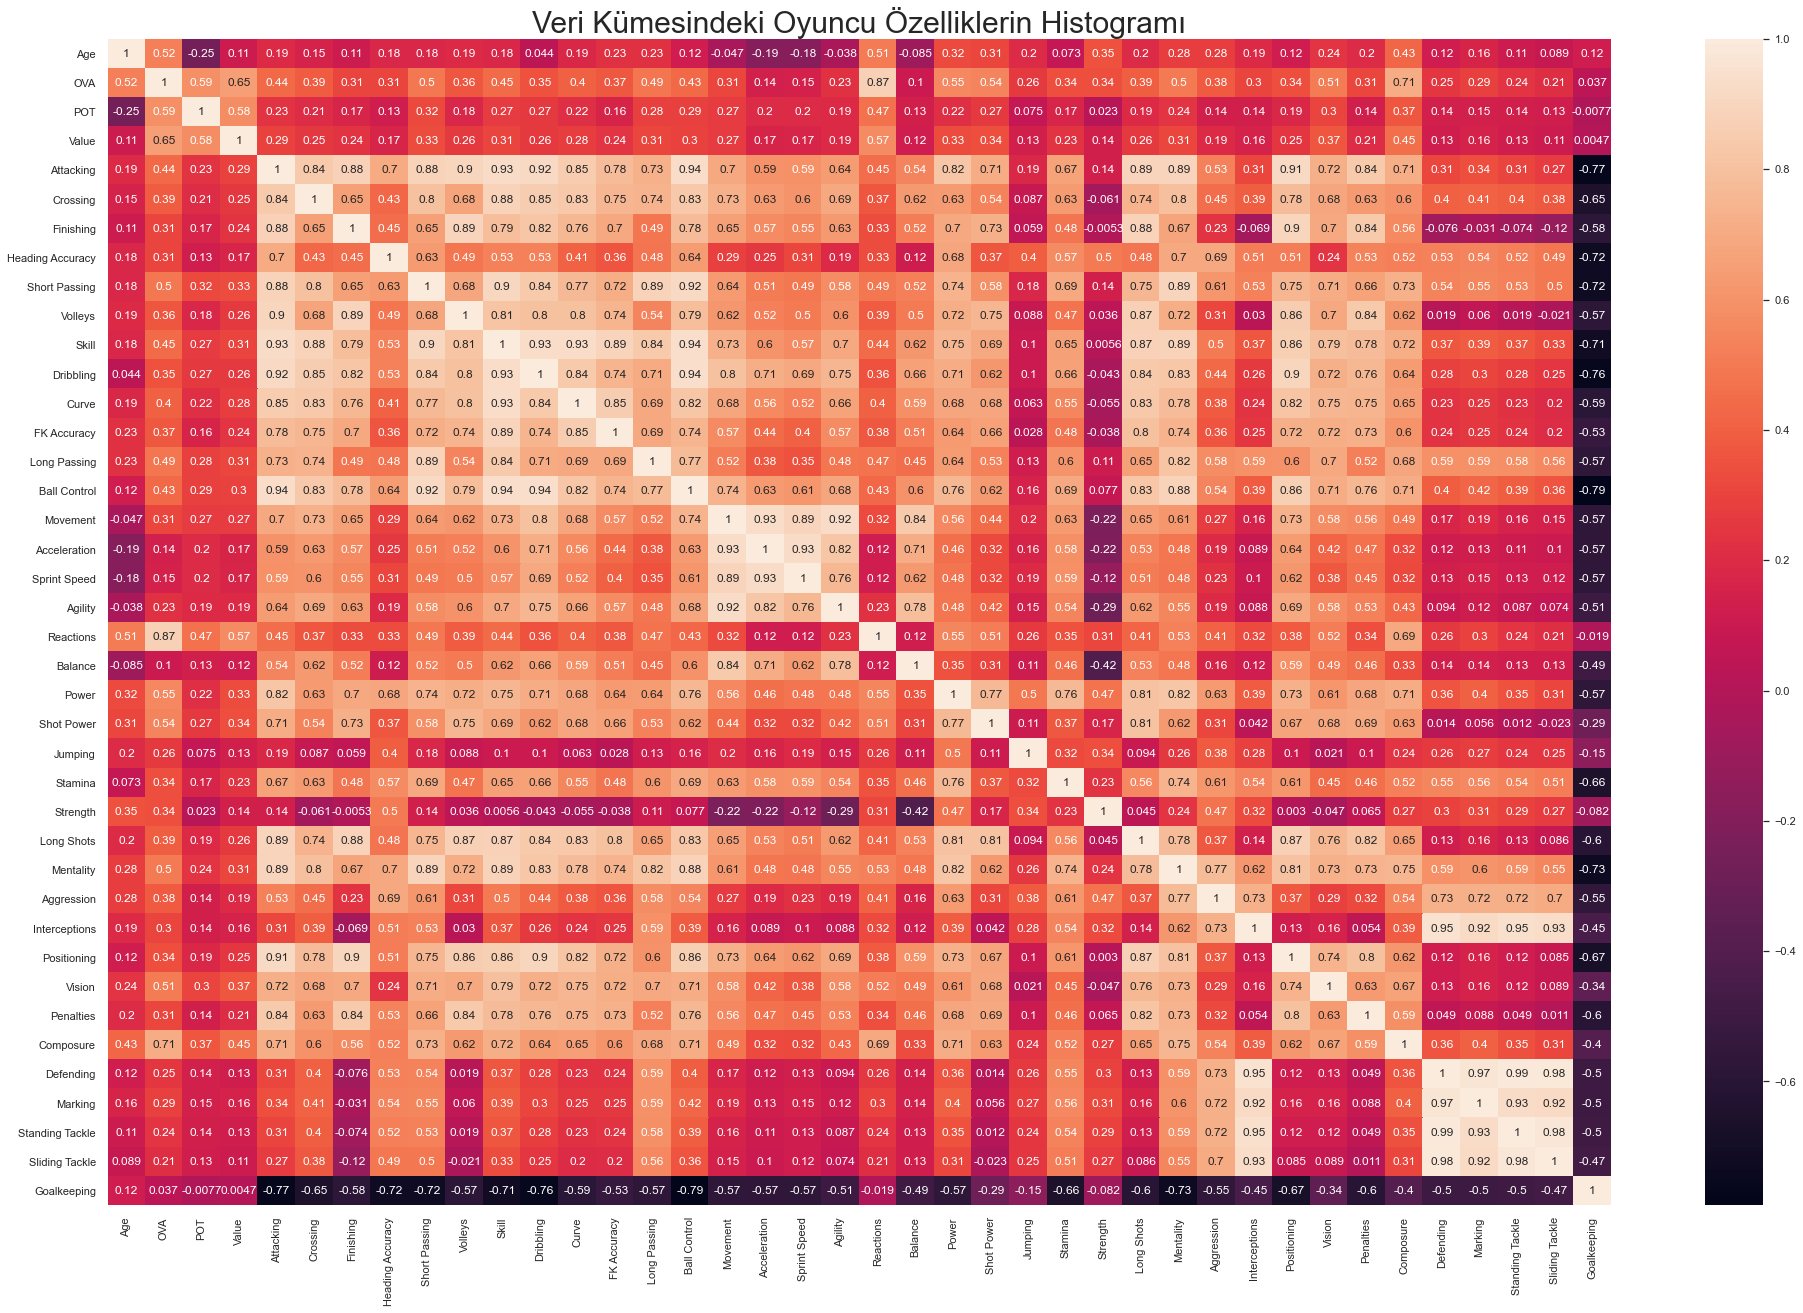

In [27]:
# Korelasyon ateş grafiği, oyuncuların puan özelliklerinden oluşturulmuştur

plt.rcParams['figure.figsize'] = (30, 20)
sns.heatmap(data[['Age', 'Nationality', 'OVA', 'POT', 'Value',
                'Release Clause', 'foot', 'Attacking', 'Crossing', 'Finishing', 'Heading Accuracy',
                'Short Passing', 'Volleys', 'Skill', 'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing',
                'Ball Control', 'Movement', 'Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance',
                'Power', 'Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots', 'Mentality', 'Aggression',
                'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Defending', 'Marking', 'Standing Tackle',
                'Sliding Tackle', 'Goalkeeping'
                 ]].corr(), annot = True)

plt.title('Veri Kümesindeki Oyuncu Özelliklerin Histogramı', fontsize = 30)
plt.show()

In [28]:
# Genel puanlarına göre yaşları, kulüpleri ve milliyetleri ile her pozisyon için en iyi oyuncular

data.loc[data.groupby(data['BP'])['OVA'].idxmax()][['BP', 'Name', 'Age', 'Club', 'Nationality']]

,BP,Name,Age,Club,Nationality
ID,,,,,
192985,CAM,K. De Bruyne,29,Manchester City,Belgium
203376,CB,V. van Dijk,28,Liverpool,Netherlands
200145,CDM,Casemiro,28,Real Madrid,Brazil
165153,CF,K. Benzema,32,Real Madrid,France
182521,CM,T. Kroos,30,Real Madrid,Germany
200389,GK,J. Oblak,27,Atlético Madrid,Slovenia
216267,LB,A. Robertson,26,Liverpool,Scotland
200104,LM,H. Son,27,Tottenham Hotspur,Korea Republic
190871,LW,Neymar Jr,28,Paris Saint-Germain,Brazil


In [29]:
# Potansiyel puanlarına göre yaş, milliyet ve kulüp ile her pozisyondan en iyi oyuncular

data.loc[data.groupby(data['BP'])['POT'].idxmax()][['BP', 'Name', 'Age', 'Club', 'Nationality']]

,BP,Name,Age,Club,Nationality
ID,,,,,
233049,CAM,J. Sancho,20,Borussia Dortmund,England
235243,CB,M. de Ligt,20,Juventus,Netherlands
212622,CDM,J. Kimmich,25,FC Bayern München,Germany
165153,CF,K. Benzema,32,Real Madrid,France
241096,CM,S. Tonali,20,Milan,Italy
192448,GK,M. ter Stegen,28,FC Barcelona,Germany
216267,LB,A. Robertson,26,Liverpool,Scotland
222492,LM,L. Sané,24,FC Bayern München,Germany
190871,LW,Neymar Jr,28,Paris Saint-Germain,Brazil


In [30]:
# Genel puanlarını karşılaştırmak için en yüksek oyuncu sayısına sahip ülkeleri seçmek

data['Nationality'].value_counts().head(8)

England        1703
Germany        1149
Spain          1119
France          982
Brazil          839
Argentina       774
Italy           560
Netherlands     467
Name: Nationality, dtype: int64

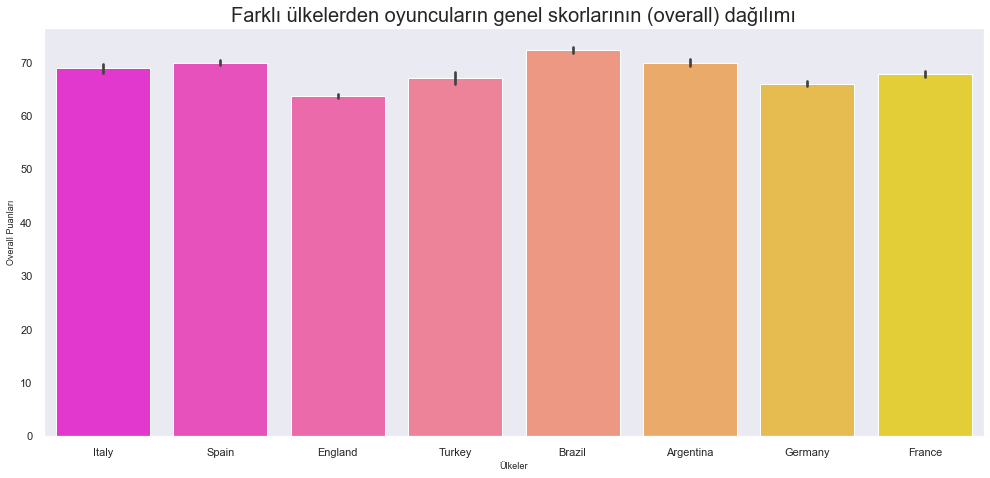

In [31]:
# Her Ulusun Oyuncusu ve genel puanları

some_countries = ('England', 'Germany', 'Spain', 'Argentina', 'France', 'Brazil', 'Italy', 'Turkey')
data_countries = data.loc[data['Nationality'].isin(some_countries) & data['OVA']]

plt.rcParams['figure.figsize'] = (15, 7)
ax = sns.barplot(x = data_countries['Nationality'], y = data_countries['OVA'], palette = 'spring')
ax.set_xlabel(xlabel = 'Ülkeler', fontsize = 9)
ax.set_ylabel(ylabel = 'Overall Puanları', fontsize = 9)
ax.set_title(label = 'Farklı ülkelerden oyuncuların genel skorlarının (overall) dağılımı', fontsize = 20)
plt.show()

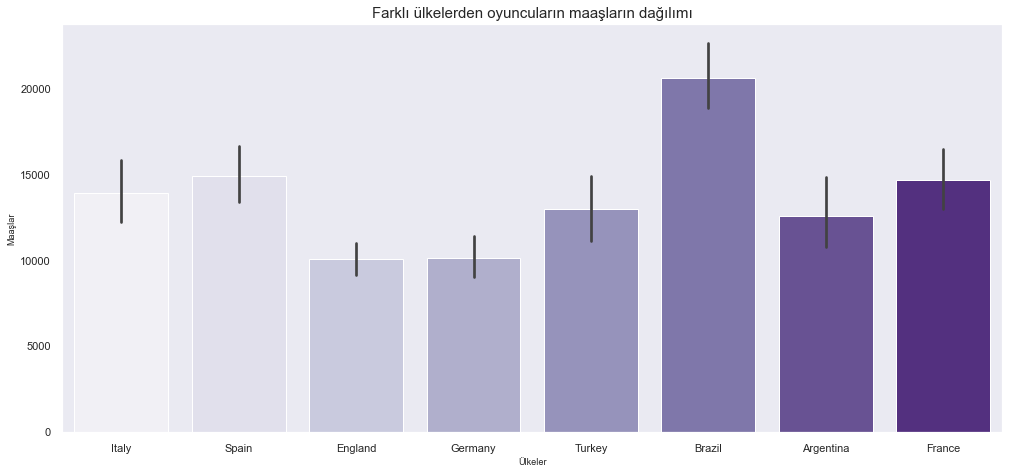

In [32]:
# Her ulusun oyuncuları ve onların ücretleri

some_countries = ('England', 'Germany', 'Spain', 'Argentina', 'France', 'Brazil', 'Italy', 'Turkey')
data_countries = data.loc[data['Nationality'].isin(some_countries) & data['Wage']]

plt.rcParams['figure.figsize'] = (15, 7)
ax = sns.barplot(x = data_countries['Nationality'], y = data_countries['Wage'], palette = 'Purples')
ax.set_xlabel(xlabel = 'Ülkeler', fontsize = 9)
ax.set_ylabel(ylabel = 'Maaşlar', fontsize = 9)
ax.set_title(label = 'Farklı ülkelerden oyuncuların maaşların dağılımı', fontsize = 15)
plt.show()

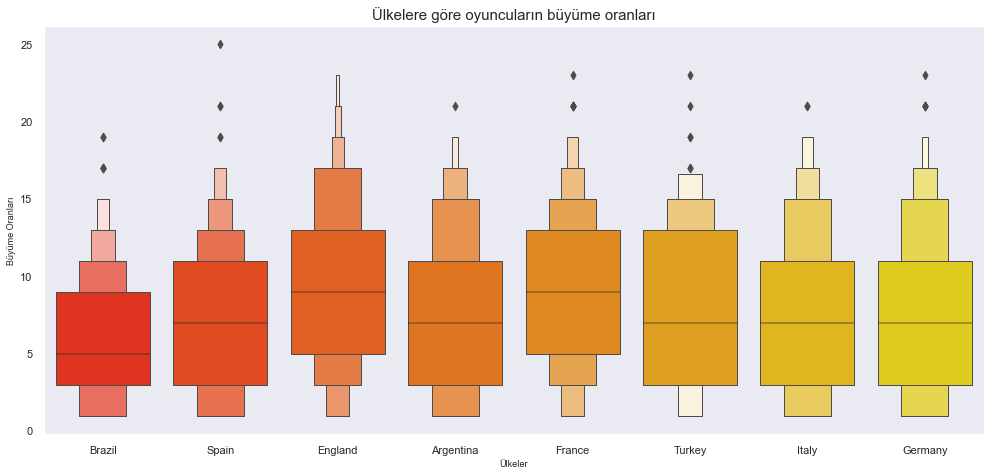

In [33]:
# Her Ulusun Oyuncusu ve büyümesi

some_countries = ('England', 'Germany', 'Spain', 'Argentina', 'France', 'Brazil', 'Italy', 'Turkey')
data_countries = data.loc[data['Nationality'].isin(some_countries) & data['Growth']]

plt.rcParams['figure.figsize'] = (15, 7)
ax = sns.boxenplot(x = data_countries['Nationality'], y = data_countries['Growth'], palette = 'autumn')
ax.set_xlabel(xlabel = 'Ülkeler', fontsize = 9)
ax.set_ylabel(ylabel = 'Büyüme Oranları', fontsize = 9)
ax.set_title(label = 'Ülkelere göre oyuncuların büyüme oranları', fontsize = 15)
plt.show()

In [34]:
# dünyadaki popüler kulüpleri bulmak

data['Club'].value_counts().head(10)

Bolton Wanderers           45
Chelsea                    44
Everton                    43
Aston Villa                43
Wolverhampton Wanderers    43
AS Monaco                  43
Arsenal                    43
Sparta Praha               42
Manchester United          42
Sunderland                 42
Name: Club, dtype: int64

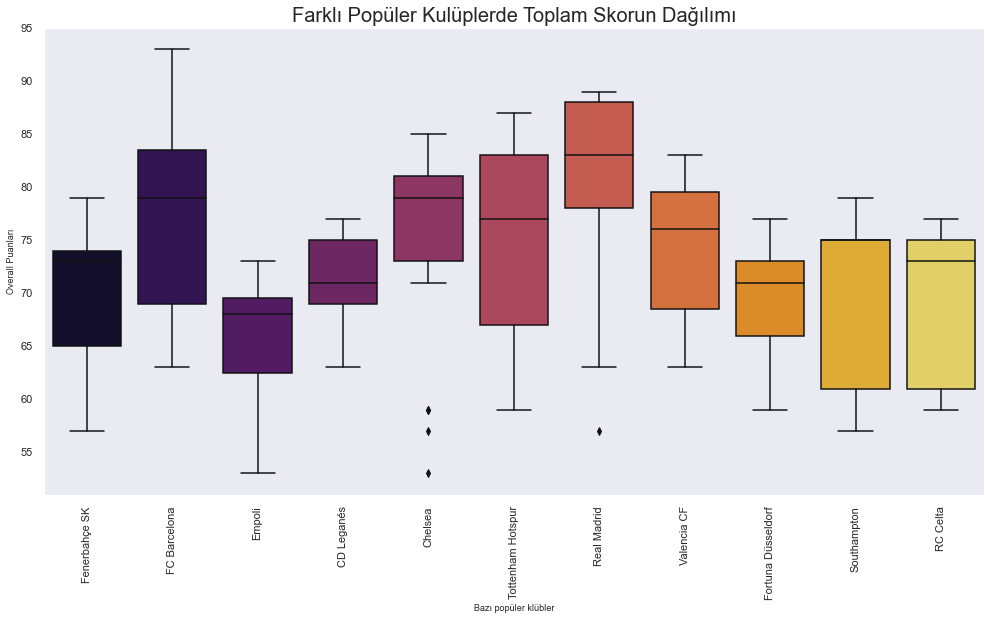

In [35]:
some_clubs = ('CD Leganés', 'Southampton', 'RC Celta', 'Empoli', 'Fortuna Düsseldorf', 'Manchestar City',
             'Tottenham Hotspur', 'FC Barcelona', 'Valencia CF', 'Chelsea', 'Real Madrid', 'Fenerbahçe SK')

data_clubs = data.loc[data['Club'].isin(some_clubs) & data['OVA']]

plt.rcParams['figure.figsize'] = (15, 8)
ax = sns.boxplot(x = data_clubs['Club'], y = data_clubs['OVA'], palette = 'inferno')
ax.set_xlabel(xlabel = 'Bazı popüler klübler', fontsize = 9)
ax.set_ylabel(ylabel = 'Overall Puanları', fontsize = 9)
ax.set_title(label = 'Farklı Popüler Kulüplerde Toplam Skorun Dağılımı', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

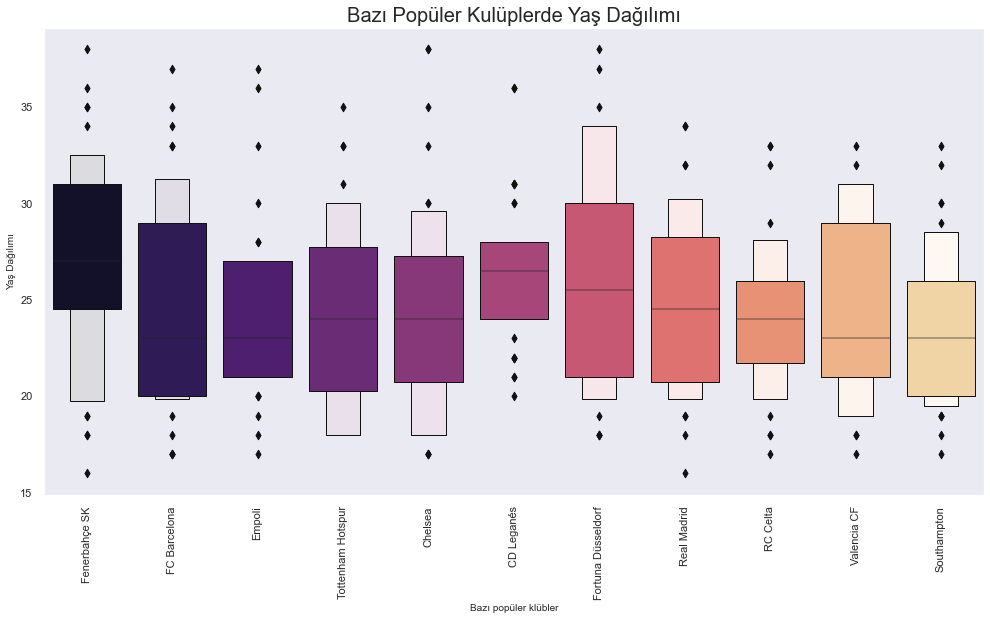

In [36]:
# Bazı Popüler Kulüplerde Yaş Dağılımı

some_clubs = ('CD Leganés', 'Southampton', 'RC Celta', 'Empoli', 'Fortuna Düsseldorf', 'Manchestar City',
             'Tottenham Hotspur', 'FC Barcelona', 'Valencia CF', 'Chelsea', 'Real Madrid', 'Fenerbahçe SK')

data_club = data.loc[data['Club'].isin(some_clubs) & data['Wage']]

plt.rcParams['figure.figsize'] = (15, 8)
ax = sns.boxenplot(x = 'Club', y = 'Age', data = data_club, palette = 'magma')
ax.set_xlabel(xlabel = 'Bazı popüler klübler', fontsize = 10)
ax.set_ylabel(ylabel = 'Yaş Dağılımı', fontsize = 10)
ax.set_title(label = 'Bazı Popüler Kulüplerde Yaş Dağılımı', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()


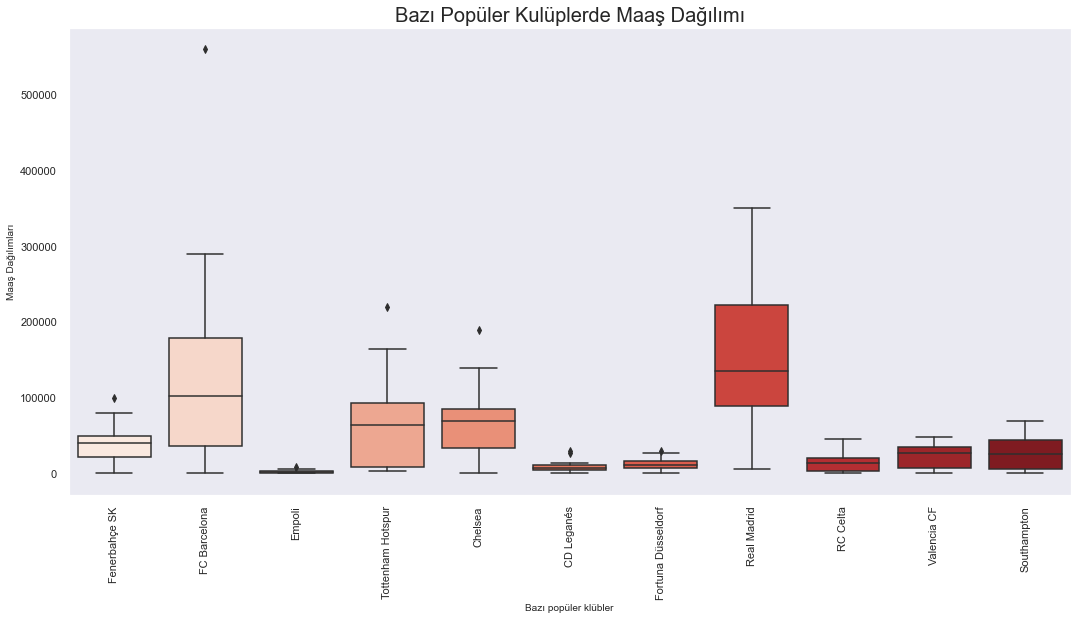

In [37]:
data_club = data.loc[data['Club'].isin(some_clubs) & data['Wage']]

plt.rcParams['figure.figsize'] = (16, 8)
ax = sns.boxplot(x = 'Club', y = 'Wage', data = data_club, palette = 'Reds')
ax.set_xlabel(xlabel = 'Bazı popüler klübler', fontsize = 10)
ax.set_ylabel(ylabel = 'Maaş Dağılımları', fontsize = 10)
ax.set_title(label = 'Bazı Popüler Kulüplerde Maaş Dağılımı', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

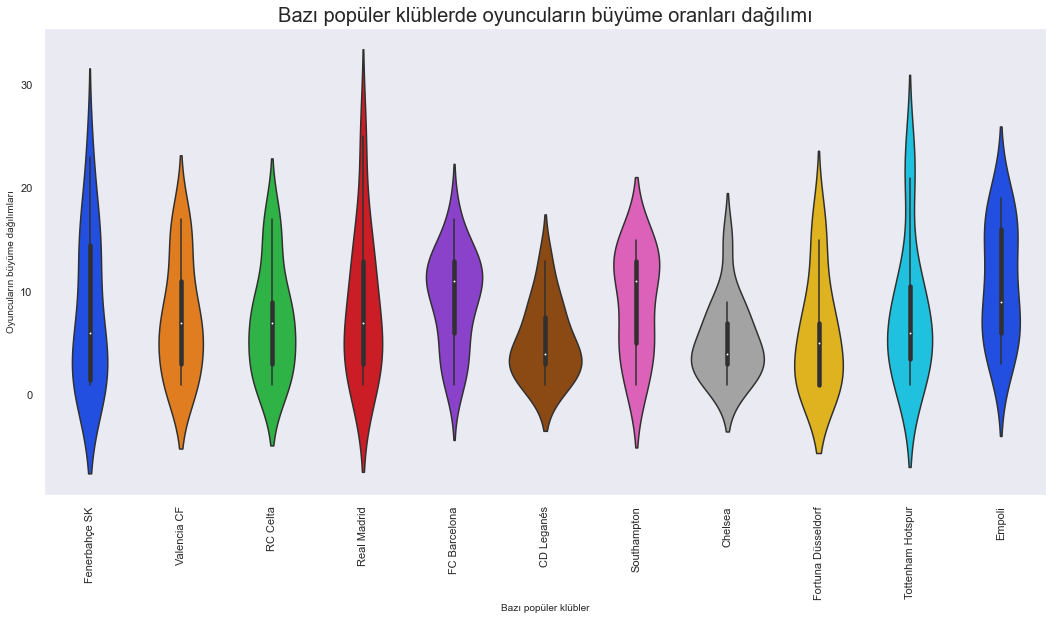

In [38]:
data_club = data.loc[data['Club'].isin(some_clubs) & data['Growth']]

plt.rcParams['figure.figsize'] = (16, 8)
ax = sns.violinplot(x = 'Club', y = 'Growth', data = data_club, palette = 'bright')
ax.set_xlabel(xlabel = 'Bazı popüler klübler', fontsize = 10)
ax.set_ylabel(ylabel = 'Oyuncuların büyüme dağılımları', fontsize = 10)
ax.set_title(label = 'Bazı popüler klüblerde oyuncuların büyüme oranları dağılımı', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

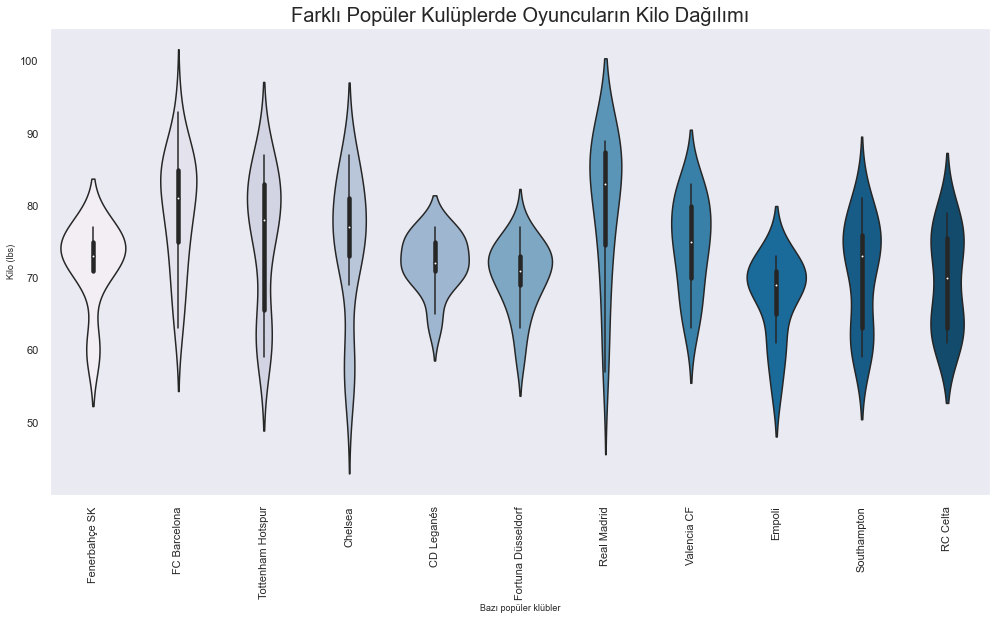

In [39]:
data_clubs = data.loc[data['Club'].isin(some_clubs) & data['BOV']]

plt.rcParams['figure.figsize'] = (15, 8)
ax = sns.violinplot(x = 'Club', y = 'BOV', data = data_clubs, palette = 'PuBu')
ax.set_xlabel(xlabel = 'Bazı popüler klübler', fontsize = 9)
ax.set_ylabel(ylabel = 'Kilo (lbs)', fontsize = 9)
ax.set_title(label = 'Farklı Popüler Kulüplerde Oyuncuların Kilo Dağılımı', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

In [40]:
# Veri kümesindeki en genç 15 oyuncuyu bulmak

youngest = data.sort_values('Age', ascending = True)[['Name', 'Age', 'Club', 'Nationality']].head(15)
youngest

,Name,Age,Club,Nationality
ID,,,,
252750,V. Covil,16,Forest Green Rovers,United States
247866,C. Miszta,16,Legia Warszawa,Poland
255558,E. Bayram,16,Galatasaray SK,Turkey
247962,M. Williamsen,16,Kristiansund BK,Norway
256970,A. Karabec,16,Sparta Praha,Czech Republic
247025,T. Gulliksen,16,Strømsgodset IF,Norway
257023,P. Johansen,16,Sandefjord Fotball,Norway
252255,Barredo,16,SD Ponferradina,Spain
251314,S. McKinstry,16,Leeds United,Scotland


In [41]:
# Veri kümesindeki en yaşlı 15 oyuncuyu bulmak

eldest = data.sort_values('Age', ascending = False)[['Name', 'Age', 'Club', 'Nationality']].head(15)
eldest

,Name,Age,Club,Nationality
ID,,,,
254704,K. Miura,53,Yokohama FC,Japan
53985,S. Royce,47,Gillingham,England
208927,H. Sulaimani,43,Al Ahli,Saudi Arabia
169108,L. Butrón,43,Alianza Lima,Peru
135708,C. Blanco,42,Club América,Mexico
684,M. Schwarzer,42,Leicester City,Australia
1179,G. Buffon,42,Juventus,Italy
143743,F. Mondragón,42,Colombia,Colombia
153260,Hilton,42,Montpellier HSC,Brazil


In [42]:
# Veri kümesindeki oyuncuların klüblerine katılma sütununa bakma

data['Joined'].head()

ID
2      Jul 1, 2008
16    Jul 19, 2014
27     Jan 7, 2016
41    Jul 16, 2018
61     Jan 1, 2011
Name: Joined, dtype: object

In [43]:
# Klüblerinde en uzun süre oynayan ilk 10 oyuncu

import datetime

now = datetime.datetime.now()
data['Join_year'] = data.Joined.dropna().map(lambda x: x.split(',')[1].split(' ')[1])
data['Years_of_member'] = (data.Join_year.dropna().map(lambda x: now.year - int(x))).astype('int')
membership = data[['Name', 'Club', 'Years_of_member']].sort_values(by = 'Years_of_member', ascending = False).head(10)
membership.set_index('Name', inplace=True)
membership

,Club,Years_of_member
Name,,
R. Giggs,Manchester United,31
Rogério Ceni,São Paulo,29
F. Totti,Roma,28
P. Scholes,Manchester United,28
J. Zanetti,Inter,26
J. Carragher,Liverpool,25
H. Sogahata,Kashima Antlers,23
L. King,Tottenham Hotspur,23
Xavi,FC Barcelona,23


In [44]:
# oyuncuların özelliklerini tanımlamak

player_features = ('Acceleration', 'Aggression', 'Agility', 
                   'Balance', 'Ball Control', 'Composure', 
                   'Crossing', 'Dribbling', 'FK Accuracy', 
                   'Finishing', 'GK Diving', 'GK Handling', 
                   'GK Kicking', 'GK Positioning', 'GK Reflexes', 
                   'Heading Accuracy', 'Interceptions', 'Jumping', 
                   'Long Passing', 'Long Shots', 'Marking', 'Penalties')

# Top four features for every position in football

for i, val in data.groupby(data['Position'])[player_features].mean().iterrows():
    print('Position {}: {}, {}, {}'.format(i, *tuple(val.nlargest(4).index)))


Position ACB: Jumping, FK Accuracy, Aggression
Position CAM: Balance, Agility, Acceleration
Position CAM CDM: Balance, Agility, Ball Control
Position CAM CDM CM: Balance, Ball Control, Long Passing
Position CAM CDM LM: Acceleration, Agility, Balance
Position CAM CF: Balance, Agility, Acceleration
Position CAM CF CM: Ball Control, Long Shots, Finishing
Position CAM CF LM: Agility, Acceleration, Jumping
Position CAM CF LW: Penalties, Composure, Dribbling
Position CAM CF RM: Agility, Balance, Acceleration
Position CAM CF RW: FK Accuracy, Penalties, Agility
Position CAM CF ST: Agility, Dribbling, Acceleration
Position CAM CM: Balance, Agility, Ball Control
Position CAM CM CDM: Balance, Agility, Acceleration
Position CAM CM CF: Ball Control, Dribbling, Agility
Position CAM CM LM: Agility, Balance, Acceleration
Position CAM CM LM RM: Composure, Agility, Acceleration
Position CAM CM LW: Agility, Balance, Dribbling
Position CAM CM RM: Balance, Agility, Ball Control
Position CAM CM RW: Balance,

Position RW LM CAM: Acceleration, Agility, Balance
Position RW LM LW: Acceleration, Agility, Balance
Position RW LM ST: Agility, Balance, Acceleration
Position RW LW: Acceleration, Agility, Balance
Position RW LW CAM: Acceleration, Balance, Agility
Position RW LW CF: Acceleration, Agility, Balance
Position RW LW LM: Acceleration, Agility, Balance
Position RW LW RB: Agility, Balance, Acceleration
Position RW LW RM: Acceleration, Balance, Agility
Position RW LW RWB: Balance, Agility, Aggression
Position RW LW ST: Acceleration, Agility, Balance
Position RW LWB LW: Acceleration, Agility, Finishing
Position RW LWB RM: Agility, Balance, Acceleration
Position RW RB: Acceleration, Agility, Balance
Position RW RB LB: Acceleration, Agility, Dribbling
Position RW RB RM: Acceleration, Agility, Balance
Position RW RM: Acceleration, Agility, Balance
Position RW RM CAM: Agility, Balance, Acceleration
Position RW RM CF: Acceleration, Dribbling, Aggression
Position RW RM LM: Acceleration, Agility, FK A

In [45]:
"""
from math import pi

idx = 1
plt.figure(figsize=(15,45))
for position_name, features in data.groupby(data['Position'])[player_features].mean().iterrows():
    top_features = dict(features.nlargest(5))
    
    # değişken sayısı
    categories=top_features.keys()
    N = len(categories)

    # Veri çerçevesinin ilk satırını çizeceğiz.
    # Ancak dairesel grafiği kapatmak için ilk değeri tekrar etmemiz gerekiyor:
    values = list(top_features.values())
    values += values[:1]

    # Özelliklerin yazılması
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Örümcek ağı grafiği oluşturma
    ax = plt.subplot(9, 3, idx, polar=True)

    # Değişken başına bir eksen çizin + etiket etiketleri ekleyin
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # ylabels çizme
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7)
    plt.ylim(0,100)
    
    plt.subplots_adjust(hspace = 0.5)
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # alanı boyama
    ax.fill(angles, values, 'b', alpha=0.1)
    
    plt.title(position_name, size=11, y=1.1)
    idx += 1 
"""

'\nfrom math import pi\n\nidx = 1\nplt.figure(figsize=(15,45))\nfor position_name, features in data.groupby(data[\'Position\'])[player_features].mean().iterrows():\n    top_features = dict(features.nlargest(5))\n    \n    # değişken sayısı\n    categories=top_features.keys()\n    N = len(categories)\n\n    # Veri çerçevesinin ilk satırını çizeceğiz.\n    # Ancak dairesel grafiği kapatmak için ilk değeri tekrar etmemiz gerekiyor:\n    values = list(top_features.values())\n    values += values[:1]\n\n    # Özelliklerin yazılması\n    angles = [n / float(N) * 2 * pi for n in range(N)]\n    angles += angles[:1]\n\n    # Örümcek ağı grafiği oluşturma\n    ax = plt.subplot(9, 3, idx, polar=True)\n\n    # Değişken başına bir eksen çizin + etiket etiketleri ekleyin\n    plt.xticks(angles[:-1], categories, color=\'grey\', size=8)\n\n    # ylabels çizme\n    ax.set_rlabel_position(0)\n    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7)\n    plt.ylim(0,100)\n    \n    plt.subplots_

In [46]:
# En iyi 10 sol ayaklı futbolcu

data[data['foot'] == 'Left'][['Name', 'Age', 'Club', 'Nationality']].head(10)

,Name,Age,Club,Nationality
ID,,,,
2,G. Pasquale,33,Udinese,Italy
80,E. Belözoğlu,38,Fenerbahçe SK,Turkey
241,R. Giggs,39,Manchester United,Wales
1040,Roberto Carlos,38,FC Anzhi Makhachkala,Brazil
2196,R. Weidenfeller,36,Borussia Dortmund,Germany
2492,Eliseu,33,SL Benfica,Portugal
2702,K. Ellison,41,Newport County,England
3712,Dida,39,Internacional,Brazil
5479,Casillas,38,FC Porto,Spain


In [47]:
# En iyi 10 sağ ayaklı futbolcu

data[data['foot'] == 'Right'][['Name', 'Age', 'Club', 'Nationality']].head(10)

,Name,Age,Club,Nationality
ID,,,,
16,Luis García,37,KAS Eupen,Spain
27,J. Cole,33,Coventry City,England
41,Iniesta,36,Vissel Kobe,Spain
61,D. Odonkor,27,Alemannia Aachen,Germany
246,P. Scholes,37,Manchester United,England
249,P. Neville,35,Everton,England
330,R. Keane,35,LA Galaxy,Republic of Ireland
684,M. Schwarzer,42,Leicester City,Australia
1041,J. Zanetti,39,Inter,Argentina


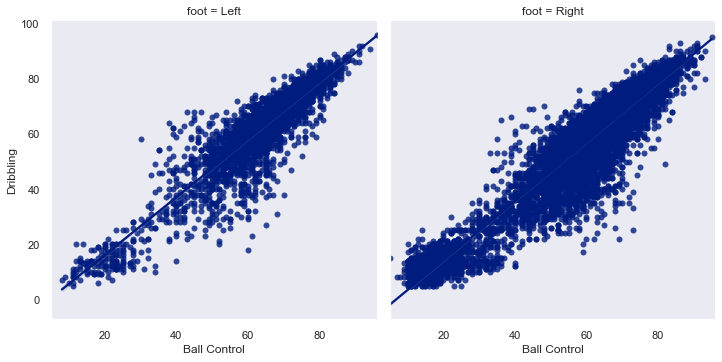

In [48]:
# sol ve sağ ayaklı futbolcuların performansını karşılaştırma
# top kontrolü vs top sürme

sns.lmplot(x = 'Ball Control', y = 'Dribbling', data = data, col = 'foot')
plt.show()


In [49]:
# en fazla sayıda farklı ülkeye sahip kulüpleri görselleştirmek

data.groupby(data['Club'])['Nationality'].nunique().sort_values(ascending = False).head(10)

Club
Lazio                  21
PAOK                   21
Liverpool              21
Fulham                 21
Leicester City         20
Inter                  20
Juventus               20
Napoli                 20
Nottingham Forest      19
TSG 1899 Hoffenheim    19
Name: Nationality, dtype: int64

In [50]:
# en az sayıda farklı ülkeye sahip kulüpleri görselleştirmek

data.groupby(data['Club'])['Nationality'].nunique().sort_values(ascending = True).head(10)

Club
Santos              1
Corinthians         1
Coritiba            1
Criciúma            1
Curicó Unido        1
Córdoba CF          1
Côte d'Ivoire       1
Cúcuta Deportivo    1
Latina              1
Sangju Sangmu FC    1
Name: Nationality, dtype: int64

In [51]:
data.columns

Index(['Name', 'Age', 'OVA', 'Nationality', 'Club', 'BOV', 'BP', 'Position',
       'Player Photo', 'Club Logo',
       ...
       'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'GK', 'Gender', 'Join_year',
       'Years_of_member'],
      dtype='object', length=108)

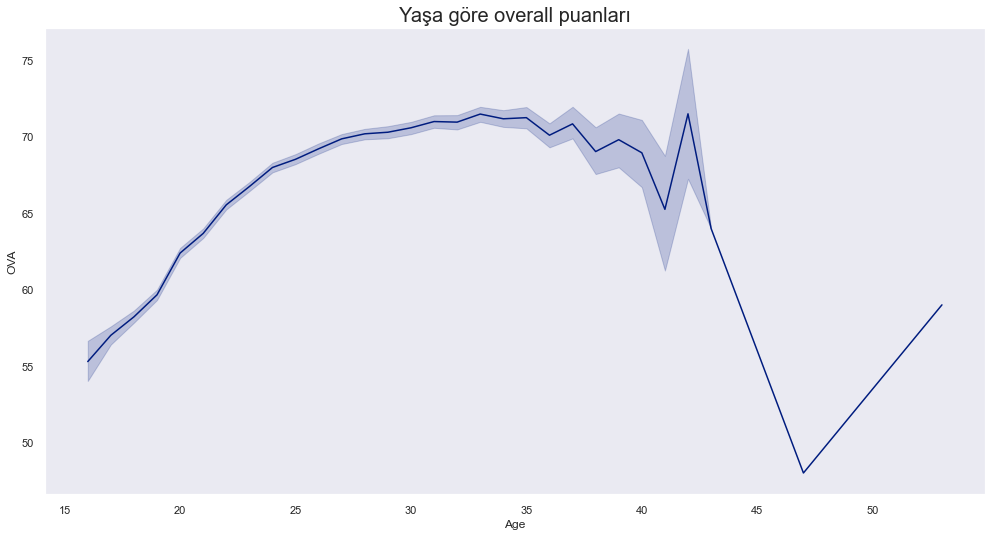

In [52]:
# Yaş ve genel skorun karşılaştırılması

sns.lineplot(data['Age'], data['OVA'], palette = 'Wistia')
plt.title('Yaşa göre overall puanları', fontsize = 20)
plt.show()

In [53]:
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected = True)
import plotly.graph_objs as go

In [54]:
# Dünya haritasında oyuncuları görselleştirme
# Oyuncuların ülkelerine göre overall değerleri

rating = pd.DataFrame(data.groupby(['Nationality'])['OVA'].sum().reset_index())
count = pd.DataFrame(rating.groupby('Nationality')['OVA'].sum().reset_index())

trace = [go.Choropleth(
            colorscale = 'YlOrRd',
            locationmode = 'country names',
            locations = count['Nationality'],
            text = count['Nationality'],
            z = count['OVA'],
)]

layout = go.Layout(title = 'Oyuncuların ülkelerine göre overall değerleri')

fig = go.Figure(data = trace, layout = layout)
py.iplot(fig)